## Example: (nonlinear) IV causal inference (no invalid IVs)
> Below is an example that demonstrates the usage of `ts_twas` in `nl_causal`.

## Simulate Data

- **library:** `nl_causal.base.sim`
- **Two Stage Datasets:** two independent datasets, **2SLS** and **2SIR** require different types of datasets:
  * For 2SLS:
    + Stage 1. LD matrix (`np.dot(Z1.T, Z1)`) + XZ_sum (`np.dot(Z1.T, X1)`)
    + Stage 2. ZY_sum (GWAS summary) (`np.dot(Z2.T, y2)`)
  * For 2SIR:
    + Stage 1. invidual-level data `Z1` and `X1`
    + Stage 2. ZY_sum (GWAS summary) (`np.dot(Z2.T, y2)`)
- **Remarks:** In terms of data, the advantage of 2SLS is merely requiring summary statistics of XZ and YZ in both Stages 1 and 2.

In [19]:
## import libraries
import numpy as np
from nl_causal.base import sim
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

## simulate a dataset
np.random.seed(3)
n, p = 5000, 10
beta0 = 0.5
theta0 = np.ones(p) / np.sqrt(p)
Z, X, y, phi = sim(n, p, theta0, beta0, case='quad', feat='cate')
## generate two-stage dataset
Z1, Z2, X1, X2, y1, y2 = train_test_split(Z, X, y, test_size=0.5, random_state=42)
n1, n2 = len(Z1), len(Z2)
LD_Z1, cov_ZX1 = np.dot(Z1.T, Z1), np.dot(Z1.T, X1)
LD_Z2, cov_ZY2 = np.dot(Z2.T, Z2), np.dot(Z2.T, y2)

╔═════════════════════════════════════╗
║ True Model                          ║
║ ----------                          ║
║ ψ(x) = z^T θ + ω;                   ║
║ y = β ψ(x) + z^T α + ε.             ║
║ ---                                 ║
║ β: causal effect from x to y.       ║
║ ψ(x): causal link among (z, x, y).  ║
║ ---                                 ║
║ True β : 0.500                      ║
║ True ψ(x) : quad                    ║
╚═════════════════════════════════════╝


In [28]:
any(X<0)

True

## Models
- **library:** `nl_causal.ts_models._2SLS` and `nl_causal.ts_models._2SIR`
- **Methods:** [2SLS](https://doi.org/10.1080/01621459.2014.994705) and [2SIR](https://openreview.net/pdf?id=cylRvJYxYI)
- **sparse regression:**
    + `sparse_reg=None`: assume all IVs are valid.
    + specify a sparse regression method from `sparse_reg` to detect invalid IVs, such as `SCAD`.
- **Remarks.** 2SIR circumvents the linearity assumption in the standard 2SLS, and includes 2SLS as a special case.

In [21]:
from nl_causal.ts_models import _2SLS, _2SIR

In [22]:
## 2SLS
LS = _2SLS(sparse_reg=None)
## Stage-1 fit theta
LS.fit_theta(LD_Z1, cov_ZX1)
## Stage-2 fit beta
LS.fit_beta(LD_Z2, cov_ZY2, n2)
## produce p_value and CI for beta
LS.test_effect(n2, LD_Z2, cov_ZY2)
LS.CI_beta(n1, n2, Z1, X1, LD_Z2, cov_ZY2)
LS.summary()

╔══════════════════════════════════════════╗
║ 2SLS                                     ║
║ ----                                     ║
║ x = z^T θ + ω;                           ║
║ y = β x + z^T α + ε.                     ║
║ ---                                      ║
║ β: causal effect from x to y.            ║
║ ---                                      ║
║ Est β (CI): 0.124 (CI: [0.008  0.2408])  ║
║ p-value: 0.0308, -log10(p): 1.5115       ║
╚══════════════════════════════════════════╝


In [23]:
## 2SIR
SIR = _2SIR(sparse_reg=None)
## Stage-1 fit theta
SIR.fit_theta(Z1, X1)
## Stage-2 fit beta
SIR.fit_beta(LD_Z2, cov_ZY2, n2)
## generate CI for beta
SIR.test_effect(n2, LD_Z2, cov_ZY2)
SIR.CI_beta(n1, n2, Z1, X1, LD_Z2, cov_ZY2)
SIR.summary()

╔══════════════════════════════════════════╗
║ 2SIR                                     ║
║ ----                                     ║
║ ψ(x) = z^T θ + ω;                        ║
║ y = β ψ(x) + z^T α + ε.                  ║
║ ---                                      ║
║ β: causal effect from x to y.            ║
║ ---                                      ║
║ Est β (CI): 0.493 (CI: [0.3798 0.6065])  ║
║ p-value: 0.0000, -log10(p): 17.4637      ║
╚══════════════════════════════════════════╝


## Results

In the simulated data, the true causal effect is `beta0 = 0.10`. 

- 2SLS provides wrong p-values and CIs, and fails to reject the null hypothesis that `H0: beta = 0`. 
- 2SIR provides a valid CI and reject the null hypothesis.

## Estimation the causal link ψ(x)
- This is only feasible for 2SIR.

In [24]:
from sklearn.neighbors import KNeighborsRegressor

## fit the causal link
SIR.cond_mean=KNeighborsRegressor(n_neighbors=20)
SIR.fit_link(Z1=Z1, X1=X1)
# evalue ψ(x) based on the estimated causal link
est_phi = SIR.link(X[:,np.newaxis])

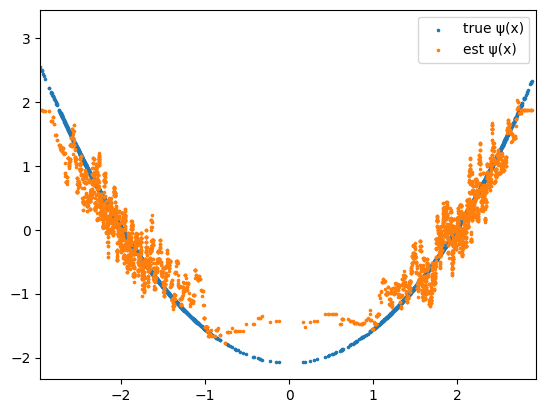

In [25]:
import matplotlib.pyplot as plt

plt.xlim(1.1*np.quantile(X,.01), 1.1*np.quantile(X,.99))
plt.scatter(X, phi, s=2.5, label='true ψ(x)')
plt.scatter(X, est_phi, s=2.5, label='est ψ(x)')
plt.legend()
plt.show()